We now try out other possible architectures, in particular `ResNet50`, `ResNet152` and `InceptionResNetV2`.

### Experiments with ResNet

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [ ]:
%run utils.ipynb

/content/drive/MyDrive/Colab Notebooks


In [ ]:
images, tip_pos = get_dataset(target_size=(224, 224), force_resize=False, rescale_coordinates=100)

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
del images

In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

#### ResNet50

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 12s 205ms/step - loss: 89.5581 - mean_absolute_error: 7.7054 - mean_euclidean_error: 15.1615 - val_loss: 59.7239 - val_mean_absolute_error: 6.3454 - val_mean_euclidean_error: 12.8497
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 45.7484 - mean_absolute_error: 5.6302 - mean_euclidean_error: 11.2486 - val_loss: 45.9839 - val_mean_absolute_error: 5.7617 - val_mean_euclidean_error: 10.9267
Epoch 3/100
10/10 [==============================] - 0s 29ms/step - loss: 35.0703 - mean_absolute_error: 4.7992 - mean_euclidean_error: 9.7243 - val_loss: 33.7331 - val_mean_absolute_error: 4.7756 - val_mean_euclidean_error: 9.6143
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 29.1035 - mean_absolute_error: 4.2962 - mean_euclidean_error: 8.6974 - val_loss: 31.3415 - val_mean_absolute_error: 4.5566 - val_mean_euclidean_error: 9.2013
Epoch 5/100
10/10 [==============================] - 0s 29ms/step 

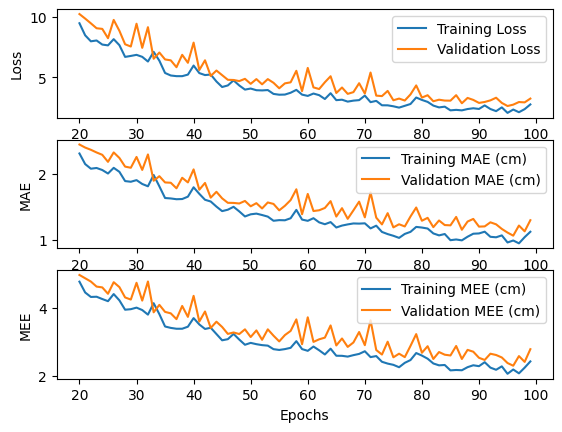

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 1s 16ms/step
103 103 103
103 103 103
x-axis: mean = 1.3442071669783555, std = 6.3417317553829236
y-axis: mean = 0.5985550030053866, std = 3.063953525858519
z-axis: mean = 0.03643091809665331, std = 0.04621242288754123


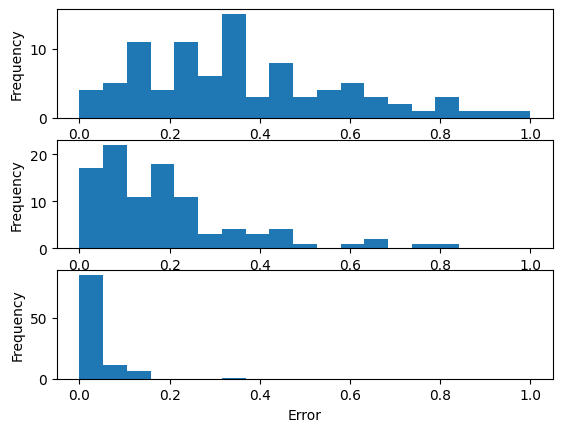

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

We see that loss, MAE and MEE are going down but are still significantly higher than VGG ones and the learning curves are a bit unstable. Moreover, the relative error distribution tells us that there is a very high "variance" in the actual precision of responses.

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 1.300620198249817
Std of MAE: 0.656170129776001
Mean of MEE: 2.784524419714709
Std of MEE: 1.4064199919917353


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [2.25815027 1.05118128 0.5925284 ]
Std of Distance along axes: [1.47725977 0.81461307 0.57479381]


In [ ]:
del model

#### ResNet152

In [ ]:
base_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

234698864/234698864 [==============================] - 12s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, None, None, 2048)  58370944  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                 301059    
                                                                 
Total params: 58,672,003
Trainable params: 301,059
Non-trainable params: 58,370,944
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 12s 365ms/step - loss: 82.2461 - mean_absolute_error: 7.4875 - mean_euclidean_error: 14.6009 - val_loss: 68.3220 - val_mean_absolute_error: 6.5254 - val_mean_euclidean_error: 13.4128
Epoch 2/100
10/10 [==============================] - 0s 51ms/step - loss: 50.1574 - mean_absolute_error: 5.7568 - mean_euclidean_error: 11.6792 - val_loss: 47.1230 - val_mean_absolute_error: 5.6783 - val_mean_euclidean_error: 10.8925
Epoch 3/100
10/10 [==============================] - 0s 52ms/step - loss: 33.9343 - mean_absolute_error: 4.6827 - mean_euclidean_error: 9.4022 - val_loss: 37.3826 - val_mean_absolute_error: 4.9597 - val_mean_euclidean_error: 10.0442
Epoch 4/100
10/10 [==============================] - 0s 50ms/step - loss: 27.8483 - mean_absolute_error: 4.0898 - mean_euclidean_error: 8.4034 - val_loss: 28.5557 - val_mean_absolute_error: 4.2547 - val_mean_euclidean_error: 8.3989
Epoch 5/100
10/10 [==============================] - 0s 50ms/step

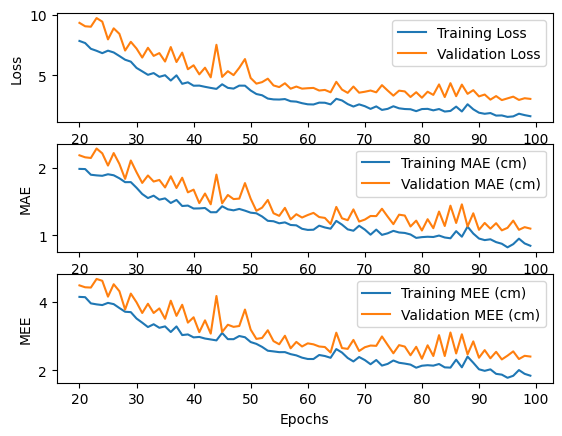

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 3s 33ms/step
103 103 103
103 103 103
x-axis: mean = 1.244408838975207, std = 5.695295037025854
y-axis: mean = 0.22678982744746948, std = 0.5809543797332607
z-axis: mean = 0.03663462949257672, std = 0.052713299291867494


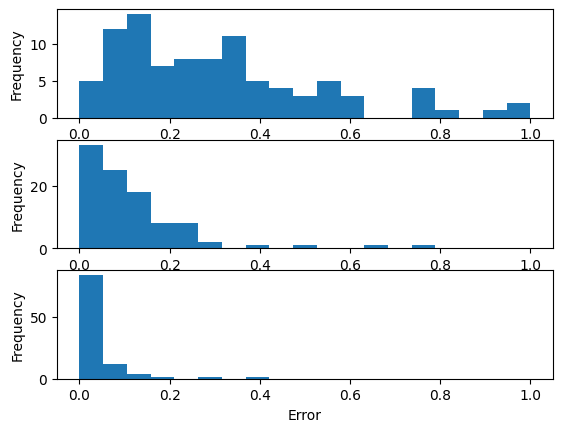

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

As we can see, the convergence is slow and unstable also in this case.

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 1.0970395803451538
Std of MAE: 0.795379638671875
Mean of MEE: 2.3959818798738497
Std of MEE: 1.8520541293430481


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [1.97461942 0.74566789 0.57083132]
Std of Distance along axes: [1.85702043 0.78181851 0.57452393]


In [ ]:
del model

### Experiments with InceptionResNetV2

In [ ]:
images, tip_pos = get_dataset(target_size=(299, 299), force_resize=False, rescale_coordinates=100)

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
del images

In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

219055592/219055592 [==============================] - 7s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 98304)             0         
                                                                 
 dense (Dense)               (None, 3)                 294915    
                                                                 
Total params: 54,631,651
Trainable params: 294,915
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
10/10 [==============================] - 29s 739ms/step - loss: 116.9456 - mean_absolute_error: 8.6735 - mean_euclidean_error: 17.4045 - val_loss: 84.6630 - val_mean_absolute_error: 7.9572 - val_mean_euclidean_error: 15.5329
Epoch 2/100
10/10 [==============================] - 2s 169ms/step - loss: 33.4660 - mean_absolute_error: 4.6377 - mean_euclidean_error: 8.9538 - val_loss: 36.9708 - val_mean_absolute_error: 5.0511 - val_mean_euclidean_error: 10.1557
Epoch 3/100
10/10 [==============================] - 2s 169ms/step - loss: 18.7681 - mean_absolute_error: 3.5045 - mean_euclidean_error: 7.0220 - val_loss: 8.6981 - val_mean_absolute_error: 2.1134 - val_mean_euclidean_error: 4.4908
Epoch 4/100
10/10 [==============================] - 2s 182ms/step - loss: 8.9971 - mean_absolute_error: 2.3939 - mean_euclidean_error: 4.8417 - val_loss: 5.0517 - val_mean_absolute_error: 1.7464 - val_mean_euclidean_error: 3.5083
Epoch 5/100
10/10 [==============================] - 2s 196ms/step

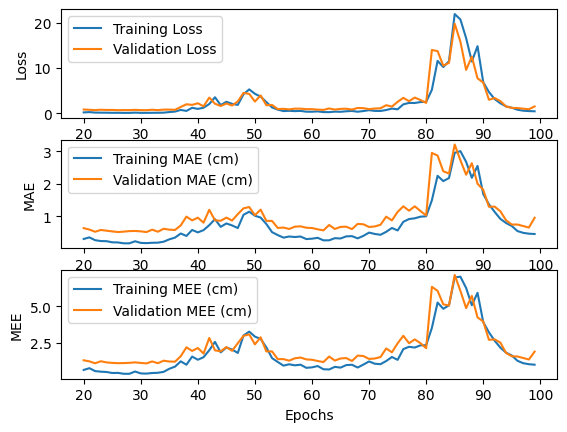

In [ ]:
%matplotlib inline
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 5s 111ms/step
103 103 103
103 103 103
x-axis: mean = 0.5719998674125266, std = 2.542606203495306
y-axis: mean = 0.8904453999319092, std = 4.11880880340141
z-axis: mean = 0.060285965158570494, std = 0.033599526139666165


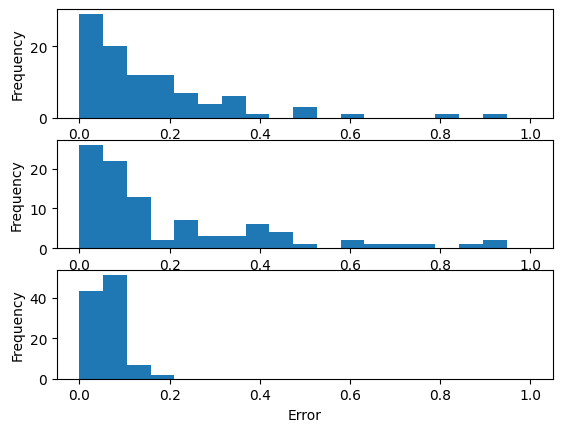

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.9591614007949829
Std of MAE: 0.4774165153503418
Mean of MEE: 1.8813962621203801
Std of MEE: 0.9303862930878871


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.77387526 1.02279675 1.08081241]
Std of Distance along axes: [0.86291415 0.72160536 0.57165011]


In [ ]:
del model

In [ ]:
images, tip_pos = get_dataset(
    target_size=(299, 299), force_resize=False, rescale_coordinates=100, **augmentation_configuration
)

In [ ]:
train_images, eval_images, train_tip_pos, eval_tip_pos = train_test_split(images, tip_pos, test_size=0.2, random_state=0)
print(f"Total length: {len(images)}", f"Training Set: {len(train_images)}", f"Validation Set: {len(eval_images)}", sep='\n')

Total length: 3078
Training Set: 2462
Validation Set: 616


In [ ]:
del images

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
finetuned_resnet50_model = tf.keras.Model(inputs, outputs)

In [ ]:
finetuned_resnet50_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 98304)             0         
                                                                 
 dense (Dense)               (None, 3)                 294915    
                                                                 
Total params: 54,631,651
Trainable params: 294,915
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
finetuned_resnet50_model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
finetuned_resnet50_history = finetuned_resnet50_model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
77/77 [==============================] - 31s 141ms/step - loss: 28.7068 - mean_absolute_error: 3.5292 - mean_euclidean_error: 7.0166 - val_loss: 2.4729 - val_mean_absolute_error: 1.1616 - val_mean_euclidean_error: 2.3618
Epoch 2/100
77/77 [==============================] - 5s 64ms/step - loss: 1.5853 - mean_absolute_error: 0.9292 - mean_euclidean_error: 1.8790 - val_loss: 1.3238 - val_mean_absolute_error: 0.8234 - val_mean_euclidean_error: 1.6989
Epoch 3/100
77/77 [==============================] - 5s 64ms/step - loss: 0.9352 - mean_absolute_error: 0.7248 - mean_euclidean_error: 1.4666 - val_loss: 1.2243 - val_mean_absolute_error: 0.8438 - val_mean_euclidean_error: 1.6910
Epoch 4/100
77/77 [==============================] - 5s 64ms/step - loss: 1.3440 - mean_absolute_error: 0.8892 - mean_euclidean_error: 1.7964 - val_loss: 1.4960 - val_mean_absolute_error: 0.9635 - val_mean_euclidean_error: 1.9306
Epoch 5/100
77/77 [==============================] - 5s 63ms/step - loss: 0.7

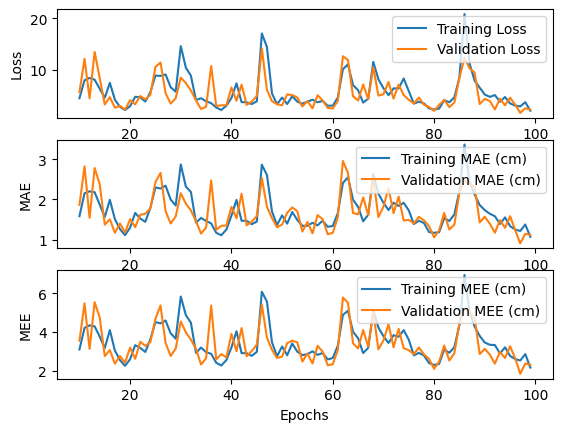

In [ ]:
%matplotlib inline
plot_metrics(
    finetuned_resnet50_history, start_epoch=10, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

20/20 [==============================] - 1s 46ms/step
616 616 616
612 612 616


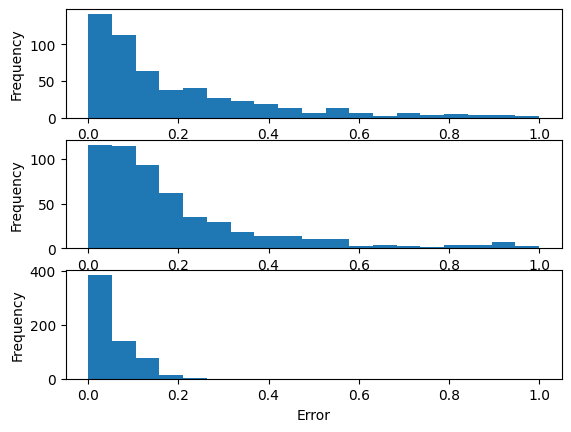

In [ ]:
epsilon = 1e-8
predictions2 = finetuned_resnet50_model.predict(eval_images)
plot_relative_errors(predictions2, eval_tip_pos, epsilon, max_error=1, nbins=20)

In [ ]:
del finetuned_resnet50_model